# MCMC fitting <a class="label-experiment" href="https://docs.easydiffraction.org/lib/glossary/#experiment-type-labels">pd-neut-cwl</a> LBCO-HRPT

This example is just a slightly modified version of the example created by Erik Fransson from Chalmers University of Technology. The original example can be found [here](https://github.com/EasyScience/EasyDiffractionLibDocs/blob/7d8d3ee51746a8a84925d306321efce8f1745054/content/tutorials/advanced/refinement_emcee.ipynb).

In this example, we take a bayesian approach to the refinement process, and rather than looking for the optimal set of parameters, we compute the probability distribution over the parameters.

## Bayesian refinement

**Goal:** Finding the posterior probability distribution over parameters, $P(\boldsymbol{x}|D)$, given some data D and prior knowledge.

* Experimental data D ($y^\text{exp}$) 
* $\boldsymbol{x}$ parameters to be refined $\boldsymbol{x}$=($\boldsymbol{x}_\text{experiment}$, $\boldsymbol{x}_\text{instrument}$, $\boldsymbol{x}_\text{sample}$)
* Simulated diffraction pattern $y^\text{sim}=f(\boldsymbol{x})$

The posterior for parameters is
\begin{equation}
\large
\underbrace{P(\boldsymbol{x}|D)}_\text{Posterior} = \underbrace{P(D|\boldsymbol{x})}_\text{Likelihood}\, \, \underbrace{P(\boldsymbol{x})}_\text{Priors}
\end{equation}

### Likelihood

We assume independent and (almost)identical normal distributed errors. But we take into account heteroscedasticity that is commonly done for diffraction data, i.e. uncertainty scales with sqrt of intensity, which be achieved by modeling the data as
\begin{equation}
\large
y^\text{exp}_i = y^\text{sim}_i + \epsilon_i \\
\large
\epsilon_i \sim \mathcal{N}(\mu=0, \sigma^2_i = \sigma^2 \cdot y^\text{exp}_i).
\end{equation}
where $\epsilon_i$ is the error between the experimental (exp) and simulated (sim) diffraction patterns.

And then we get a likelihood that looks like
\begin{equation}
\large
P(D|\boldsymbol{x}) \propto \exp{\left (- \frac{\sum_i (y^\text{sim}_i- y^\text{exp}_i)^2 }{\sigma^2 y^\text{exp}_i}\right )}
\end{equation}
Note here that $\sigma$ is also a free parameter that we need to include in our modeling.

### Priors

In this example, we encode no information in the priors, but in princple any prior knowledge about the same could and should be encoded in the prior probability distribution.

### Posterior 

Finding parameters that maximizes the posterior is equvivalent to regular optimization (least-squares).

Obtaining the posterior probability distribution is done via MCMC-sampling with `emcee`, see their [documentation](https://emcee.readthedocs.io/en/stable/) for more details.

### More information

See the "Use of Bayesian Inference in Crystallographic Structure Refinement via Full Diffraction Profile Analysis" (doi: https://doi.org/10.1038/srep31625), for more information.

## Import dependencies

In [1]:
import corner  # Library for plotting posterior distributions
import emcee  # Library for Markov chain Monte Carlo (MCMC) sampling
import matplotlib.pyplot as plt  # Plotting library
import numpy as np  # Numerical library

import easydiffraction as ed

## Helper functions

Here we let `theta` be the parameter vector (including $\sigma$).

In [2]:
# helper functions


def compute_rmse(y_target, y_predicted):
    """
    Compute root mean squared error (RMSE) between
    target and predicted values
    """
    delta_y = y_target - y_predicted
    rmse = np.sqrt(np.mean(delta_y**2))
    return rmse


def compute_mse_weighted(y_target, y_predicted):
    """
    Compute the weighted mean squared error.
    (weighting by y_target)
    """
    delta_y = y_target - y_predicted
    weight = y_target
    mse_weighted = np.mean(delta_y**2 / weight)
    return mse_weighted

In [3]:
# theta_0 is close to a least-square solution
theta_0 = np.array([2.0, 3.89, 9.0, 0.6,
                    0.08, -0.12,
                    0.12, 0.08,
                    172, 172])
parameter_names = ['sigma', 'length_a', 'scale', 'zero_shift',
                   'resolution_u', 'resolution_v',
                   'resolution_w', 'resolution_y',
                   'intensity', 'intensity-1']


def generate_starting_theta():
    """
    Generate random initial starting point pretty close to theta_0
    """

    # parameters defining how much randomness to add to theta_0
    dx_sigma = 1
    dx_lattice_parameter = 0.01
    dx_scale = 0.1
    dx_zeroshift = 0.03
    dx_reso = 0.01
    dx_bkg = 5

    # randomize theta
    theta = theta_0.copy()
    theta[0] += np.random.uniform(-dx_sigma, dx_sigma)

    for i in [1]:
        theta[i] += np.random.uniform(-dx_lattice_parameter,
                                      dx_lattice_parameter)

    theta[2] += np.random.uniform(-dx_scale, dx_scale)
    theta[3] += np.random.uniform(-dx_zeroshift, dx_zeroshift)

    theta[4] += np.random.uniform(-dx_reso, dx_reso)
    theta[5] += np.random.uniform(-dx_reso, dx_reso)
    theta[6] += np.random.uniform(-dx_reso, dx_reso)
    theta[7] += np.random.uniform(-dx_reso, dx_reso)

    theta[8] += np.random.uniform(-dx_bkg, dx_bkg)
    theta[9] += np.random.uniform(-dx_bkg, dx_bkg)

    return theta


def set_job_parameters(job, theta):
    """
    Set all the parameters for the job.
    theta[0] is sigma and is thus not used
    """

    job.phases[0].cell.length_a = theta[1]
    job.phases[0].scale = theta[2]
    job.pattern.zero_shift = theta[3]
    job.parameters.resolution_u = theta[4]
    job.parameters.resolution_v = theta[5]
    job.parameters.resolution_w = theta[6]
    job.parameters.resolution_y = theta[7]
    job.backgrounds[0][0].y = theta[8]
    job.backgrounds[0][1].y = theta[9]

## Probability functions

In [4]:
# define all probabilities, priors, likelihoods, posteriors


def log_gaussian_likelihood(theta):

    # set parameters
    sigma = theta[0]
    set_job_parameters(job, theta)

    # if the calculation fails for any reason, return -inf
    try:
        y_predicted = job.calculate_profile()
    except ArithmeticError:
        return -np.inf

    # if y contains nan then return -inf
    if np.any(np.isnan(y_predicted)):
        return -np.inf

    # compute log-likelihood
    sigmas = sigma * np.sqrt(meas_y)
    LL = -0.5 * np.sum(np.log(2 * np.pi * sigmas ** 2) +
                       (meas_y - y_predicted) ** 2 / sigmas ** 2)
    return LL


def log_prior(theta):
    sigma = theta[0]
    if sigma < 0 or sigma > 1000:
        return -np.inf
    return 0


def log_posterior(theta):
    return log_prior(theta) + log_gaussian_likelihood(theta)

## Load the data and setup Job

In [5]:
# create a job
job = ed.Job()

# load cif
ed.download_from_repository('lbco_adp.cif', destination='data')
cif_fname = 'data/lbco_adp.cif'
job.add_phase_from_file(cif_fname)

# load diffraction data
ed.download_from_repository('hrpt.xye', destination='data')
meas_fname = 'data/hrpt.xye'
meas_x, meas_y, meas_e = np.loadtxt(meas_fname, unpack=True)
print('Data shape:', meas_x.shape, meas_y.shape)
job.add_experiment_from_file(meas_fname)

Data shape: (3098,) (3098,)


In [6]:
# setup
job.parameters.wavelength = 1.494

# add background
job.set_background([(meas_x[0], 170),
                    (meas_x[-1], 170)])

Note here that no parameters are set to be refined. The MCMC simulations will be carried out using `emcee` package which will use the `log_posterior` function to sample the posterior.
The `job` will only be used to calculate the diffraction pattern for the parameters that `emcee` will sample.

Initial: RMSE 26.503, MSE-weighted 1.561


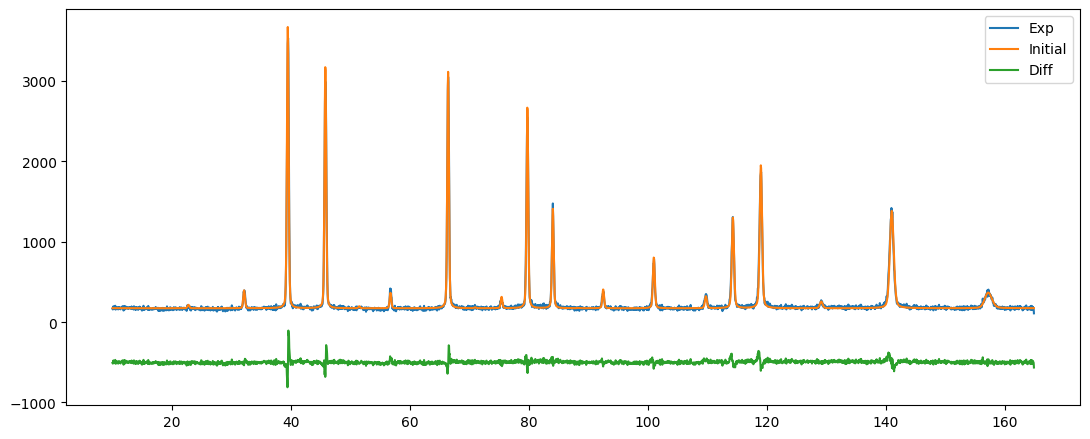

In [7]:
# Check if theta_0 is reasonable
set_job_parameters(job, theta_0)
y_initial = job.calculate_profile()
rmse_initial = compute_rmse(meas_y, y_initial)
msew_initial = compute_mse_weighted(meas_y, y_initial)
print(f'Initial: RMSE {rmse_initial:.3f}, MSE-weighted {msew_initial:.3f}')

# plot
fig = plt.figure(figsize=(11, 4.5))
plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y_initial, label='Initial')
plt.plot(meas_x, meas_y - y_initial-500, label='Diff')
plt.legend()
fig.tight_layout()

## Run MCMC sampling

Next, we define the hyper-parameters to be used for the MCMC sampling

The MCMC is carried out by multiple independent "walkers".

* `n_steps` sets how many steps/iterations each walker will carry out
* `n_walkers` sets how many walkers to use
* `n_parameters` is the total number of parameters being optimized
* `n_every` how often to record store the MCMC trajectory


In [8]:
# MCMC parameters
n_walkers = 15            # number of MCMC walkers
n_every = 1               # keep every x:th sample
n_steps = 1000 // n_every # steps per walker
n_parameters = 10         # number of parameters

Next, we generate the starting parameters for all walkers.

In [9]:
# generate starting points for walkers
theta_start = [theta_0.copy()]
for _ in range(n_walkers-1):
    theta_start.append(generate_starting_theta())
theta_start = np.array(theta_start).copy()
print('theta start shape:', theta_start.shape)

# sanity check starting points such that there is no horribly starting points with e.g. NaNs
for it, theta in enumerate(theta_start):
    set_job_parameters(job, theta)
    y = job.calculate_profile()
    rmse = compute_rmse(meas_y, y)
    msew = compute_mse_weighted(meas_y, y)
    logp = log_posterior(theta)

    print(f'Walker {it:2}: log-posterior {logp:11.5f} | RMSE {rmse:.3f} | MSE-weighted {msew:.3f}')

theta start shape: (15, 10)
Walker  0: log-posterior -13788.56594 | RMSE 26.503 | MSE-weighted 1.561
Walker  1: log-posterior -28284.96448 | RMSE 94.785 | MSE-weighted 12.004
Walker  2: log-posterior -19814.74938 | RMSE 136.556 | MSE-weighted 23.895
Walker  3: log-posterior -27788.83954 | RMSE 115.817 | MSE-weighted 12.446
Walker  4: log-posterior -14679.93963 | RMSE 42.511 | MSE-weighted 2.668
Walker  5: log-posterior -14734.93489 | RMSE 53.285 | MSE-weighted 2.946
Walker  6: log-posterior -16002.82980 | RMSE 89.051 | MSE-weighted 7.853
Walker  7: log-posterior -16725.05550 | RMSE 111.820 | MSE-weighted 12.785
Walker  8: log-posterior -36356.28704 | RMSE 237.575 | MSE-weighted 92.157
Walker  9: log-posterior -20544.42476 | RMSE 163.019 | MSE-weighted 29.857
Walker 10: log-posterior -14188.84818 | RMSE 41.946 | MSE-weighted 2.774
Walker 11: log-posterior -28329.06082 | RMSE 115.493 | MSE-weighted 18.974
Walker 12: log-posterior -14062.19162 | RMSE 44.561 | MSE-weighted 2.593
Walker 13:

In order make emcee run with fewer walkers than twice the number of parameters, we need to set `sampler._moves[0].live_dangerously = True`, but this is often unadvisable.

Due to the starting points for the walkers being quite similar we also may need to set `skip_initial_state_check=True` in order to avoid poor conditioned starting point error.


In [10]:
# sample
sampler = emcee.EnsembleSampler(n_walkers, n_parameters, log_posterior)
sampler._moves[0].live_dangerously = True
sampler.run_mcmc(theta_start, n_steps, progress=True, thin_by=n_every, skip_initial_state_check=True)
print('Done!')

100%|██████████| 1000/1000 [12:49<00:00,  1.30it/s]

Done!


In [11]:
samples = sampler.chain
logp = sampler.lnprobability
steps = n_every * np.arange(0, samples.shape[1])
print('samples shape:', samples.shape)

samples shape: (15, 1000, 10)


First we'll plot the posterior of all walkers to check convergence.

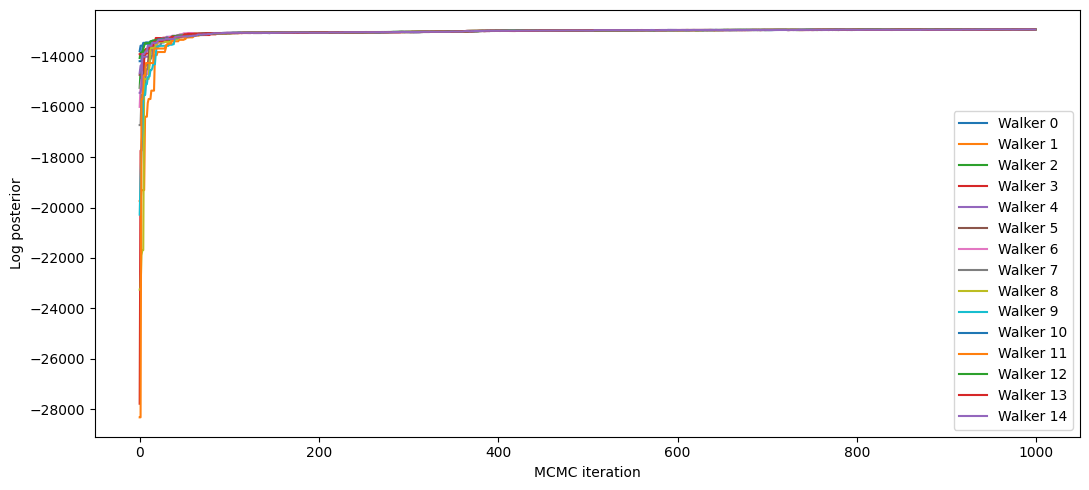

In [12]:
fig = plt.figure(figsize=(11, 5))
for walker_ind in range(n_walkers):
    plt.plot(steps, logp[walker_ind, :], label=f'Walker {walker_ind}')
plt.legend()
plt.ylabel('Log posterior')
plt.xlabel('MCMC iteration')
fig.tight_layout()

Next, we'll plot the MCMC trajectory of the parameters for a few walkers

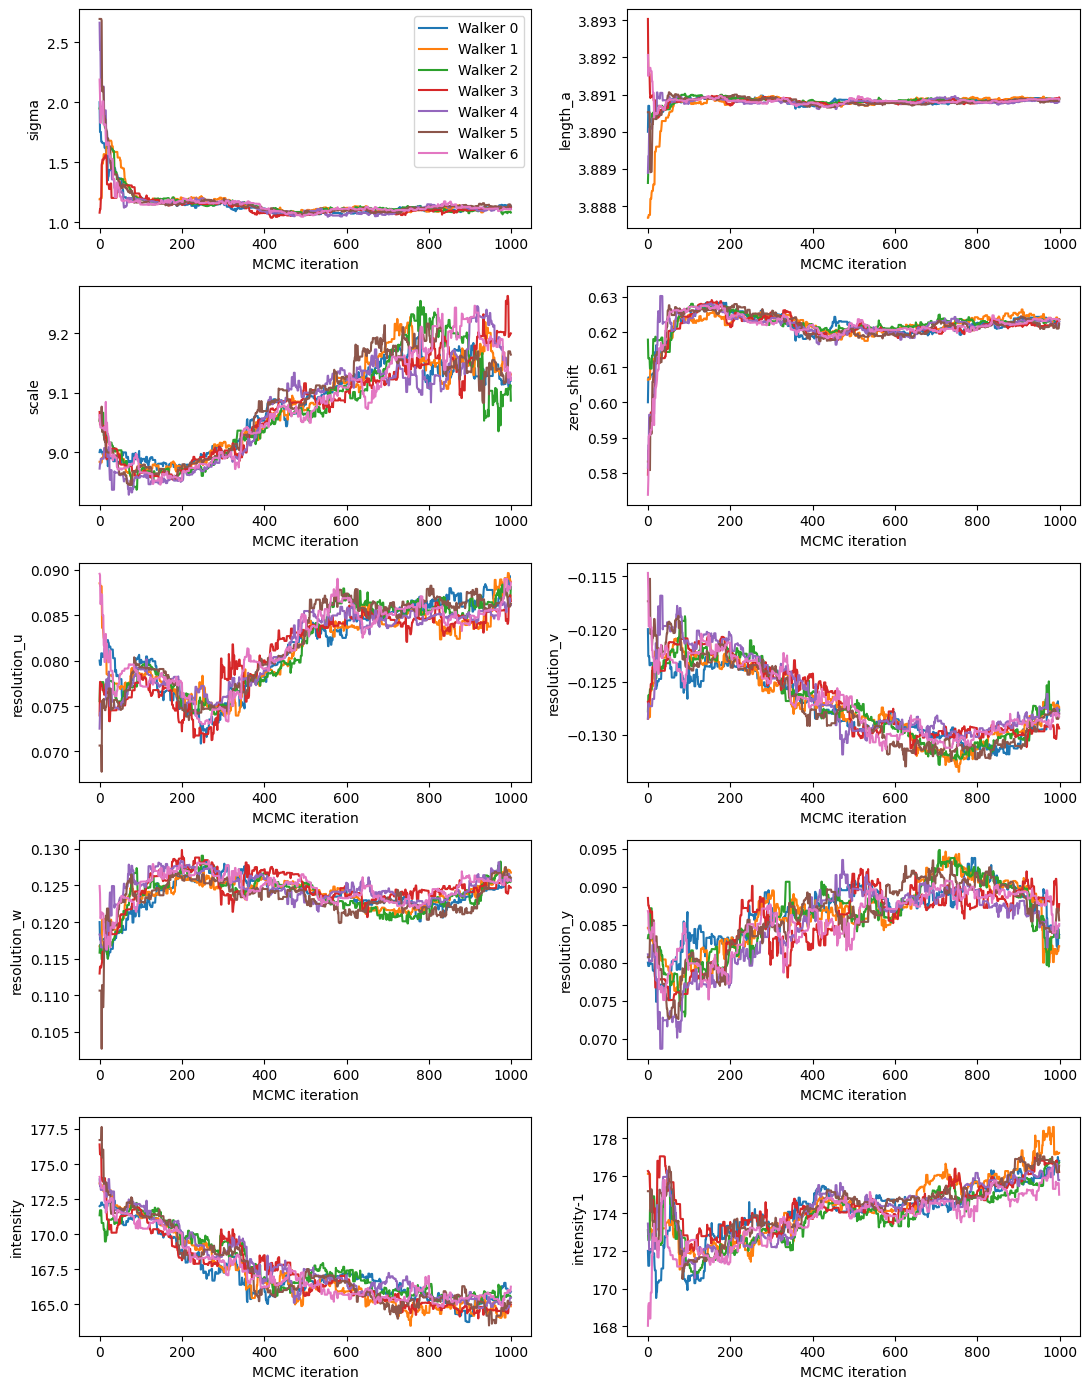

In [13]:
walkers_to_plot = [0, 1, 2, 3, 4, 5, 6]

fig, axes = plt.subplots(5, 2, figsize=(11, 14))
for i in range(n_parameters):
    ax = axes.flat[i]
    name = parameter_names[i]
    for walker_ind in walkers_to_plot:
        ax.plot(steps, samples[walker_ind, :, i], label=f'Walker {walker_ind}')
    ax.set_ylabel(name)
    ax.set_xlabel('MCMC iteration')
    if i == 0:
        ax.legend(loc=1)

fig.tight_layout()
plt.show()

Now we extract the optimal choice of parameters and their standard-deviation.    
We throw away the equilibration period of the MCMC simulations.



In [14]:
n_throw_away = 500 // n_every  # number of equilibration steps to throw away
samples_flat = samples[:, n_throw_away:, :].reshape(-1, n_parameters)
print('samples shape: ', samples.shape)
print('samples_flat shape:', samples_flat.shape)

samples shape:  (15, 1000, 10)
samples_flat shape: (7500, 10)


In [15]:
# select best model
ind = np.argmax(logp)
hp_loc = np.unravel_index(ind, logp.shape)
theta_best = samples[hp_loc]

# calculate spectra with best model
set_job_parameters(job, theta_best)
y = job.calculate_profile()
rmse_refined = compute_rmse(meas_y, y)
msew_refined = compute_mse_weighted(meas_y, y)
print(f'Best model: RMSE {rmse_refined:.3f}, MSE-weighted {msew_refined:.3f}, sigma {theta_best[0]:.3f}')

# estimate errors of parameters
stds = samples_flat.std(axis=0)

# Save the data to be analyzed
data = dict(names=parameter_names, steps=steps, samples=samples, logp=logp)
parameter_dict = dict()
for name, val, err in zip(parameter_names, theta_best, stds):
    key = name
    if name in parameter_dict:
        key = key + '-1'
    print(f'{key:15} {val:12.5f} , err {err:8.5f}')
    parameter_dict[key] = val, err
data['parameters'] = parameter_dict

Best model: RMSE 18.881, MSE-weighted 1.246, sigma 1.126
sigma                1.12602 , err  0.02130
length_a             3.89089 , err  0.00004
scale                9.14524 , err  0.04485
zero_shift           0.62344 , err  0.00141
resolution_u         0.08760 , err  0.00147
resolution_v        -0.12728 , err  0.00118
resolution_w         0.12579 , err  0.00130
resolution_y         0.08274 , err  0.00240
intensity          165.87849 , err  0.79135
intensity-1        176.49258 , err  0.88823


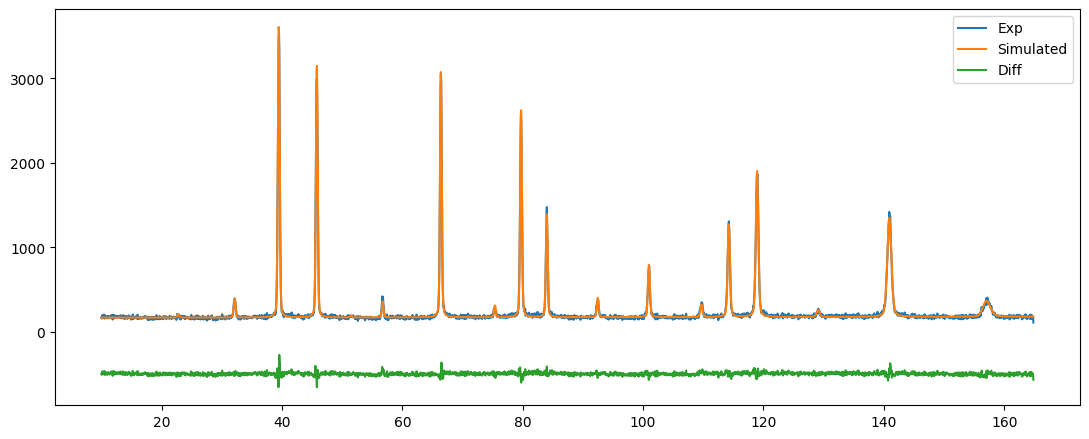

In [16]:
# plot diffraction pattern after refinement
fig = plt.figure(figsize=(11, 4.5))
plt.plot(meas_x, meas_y, label='Exp')
plt.plot(meas_x, y, label='Simulated')
plt.plot(meas_x, meas_y - y-500, label='Diff')
plt.legend()
fig.tight_layout()

<Figure size 1200x1200 with 0 Axes>

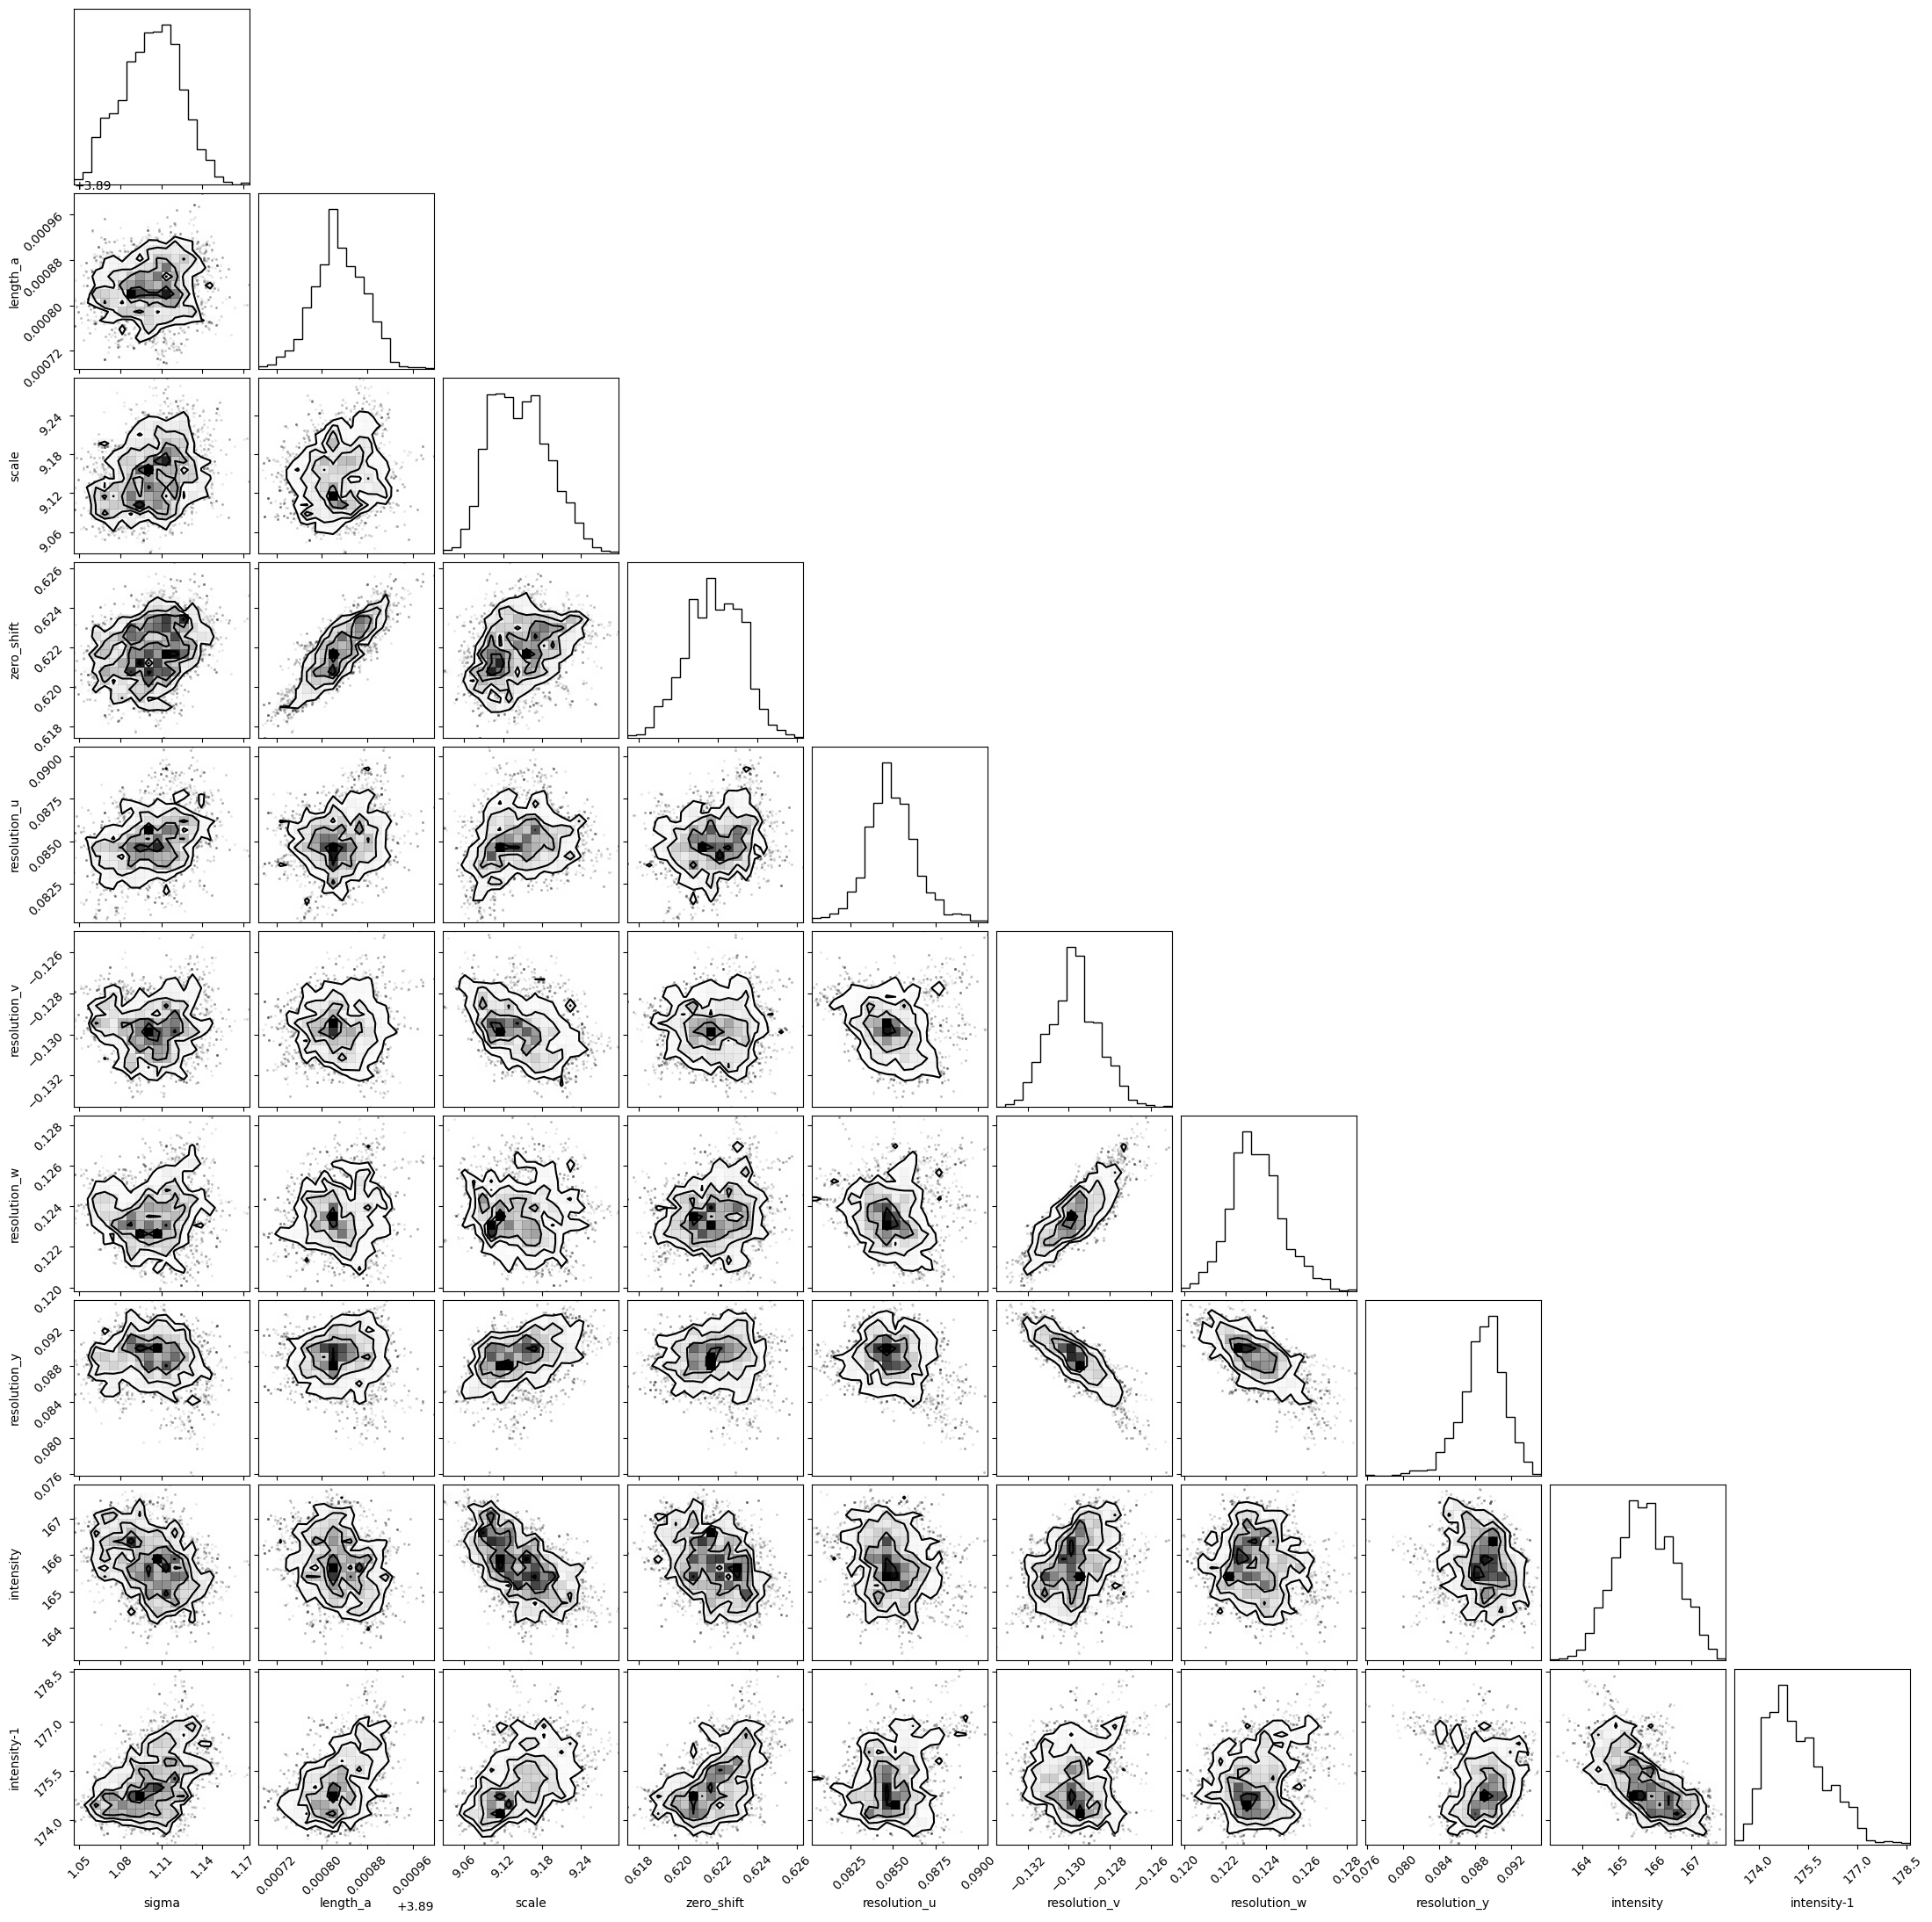

In [17]:
# corner plot
fig = plt.figure(figsize=(12, 12))
corner.corner(samples_flat, labels=parameter_names)
fig.tight_layout()